# AutoMLPipeline and AutoOfflineRL Overview
</br>


#####     Presentor: Paulito Palmes, IBM Research
#####          Date: November 21, 2024 

# OUTLINE

- ## Part 1
    - ### Introduction to AutoMLPipeline Workflow
    - ### Using Transformers and Learners and their Combinations
    - ### Single-stage vs Two-stage Parallel Processing for Optimal Pipeline Search
    - ### Explainability in AutoMLPipeline
    - ### Using Workflow Templates for Zero-touch coding of AutoMLPipeline in Kubernetes Cluster
- ## Part 2
    - ### Introduction to AutoOfflineRL
    - ### AutoOfflineRL in Cluster Resource Management Workload Pre-emption
    - ### Discussion/Comparison of Different RL Agents Solutions for Workload Pre-emption

## Introduction to AutoMLPipeline Workflow

- #### Load ML pipeline preprocessing components and models
- #### Creating and Evaluating Preprocessing Pipelines

### Load ML pipeline preprocessing components and models

In [1]:
using AutoMLPipeline
import PythonCall; const PYC=PythonCall; warnings = PYC.pyimport("warnings"); warnings.filterwarnings("ignore")
using AbstractTrees
using DataFrames
using Statistics
using ShapML
using RDatasets
using Gadfly

# load filters
#### Decomposition
pca = SKPreprocessor("PCA"); 
fa = SKPreprocessor("FactorAnalysis"); 
ica = SKPreprocessor("FastICA");

#### Scaler 
rb = SKPreprocessor("RobustScaler"); 
pt = SKPreprocessor("PowerTransformer"); 
norm = SKPreprocessor("Normalizer"); 
mx = SKPreprocessor("MinMaxScaler");

#### categorical preprocessing
ohe = OneHotEncoder()

#### Column selector
catf = CatFeatureSelector(); 
numf = NumFeatureSelector();

#### Learners
rf = SKLearner("RandomForestClassifier",Dict(:impl_args=>Dict(:n_estimators => 100))); 
gb = SKLearner("GradientBoostingClassifier");
lsvc = SKLearner("LinearSVC");     
mlp = SKLearner("MLPClassifier");  
jrf = RandomForest(); 
stack = StackEnsemble(); 
svc = SKLearner("SVC");
ada = SKLearner("AdaBoostClassifier");
vote = VoteEnsemble();
rfr = skoperator("RandomForestRegressor");
gbr = skoperator("GradientBoostingRegressor");
best = BestLearner();

    CondaPkg Found dependencies: /Users/ppalmes/.julia/packages/AutoMLPipeline/ar1Dk/CondaPkg.toml
    CondaPkg Found dependencies: /Users/ppalmes/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Dependencies already up to date


### Prepare dataset for classification

In [2]:
# Make sure that the input feature is a dataframe and the target output is a 1-D vector.
profbdata = getprofb()
X = profbdata[:,2:end] 
Y = profbdata[:,1] |> Vector;
head(x)=first(x,10)
head(profbdata)

Row,Home.Away,Favorite_Points,Underdog_Points,Pointspread,Favorite_Name,Underdog_name,Year
,String7,Int64,Int64,Float64,String3,String3,Int64
1,away,27,24,4.0,BUF,MIA,89
2,at_home,17,14,3.0,CHI,CIN,89
3,away,51,0,2.5,CLE,PIT,89
4,at_home,28,0,5.5,NO,DAL,89
5,at_home,38,7,5.5,MIN,HOU,89
6,at_home,34,20,6.0,DEN,KC,89
7,away,31,21,6.0,LAN,ATL,89
8,at_home,24,27,2.5,NYJ,NE,89
9,away,16,13,1.5,PHX,DET,89


### Pipeline to transform categorical features to one-hot encoding

In [3]:
pohe = catf |> ohe
tr = fit_transform!(pohe,X,Y)
head(tr)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pipeline to transform numerical features to pca and ica and concatenate them

In [4]:
pdec = (numf |> pca) + (numf |> ica)
tr = fit_transform!(pdec,X,Y)
head(tr)

Row,x1,x2,x3,x4,x1_1,x2_1,x3_1,x4_1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.47477,7.87074,-1.10495,-0.902431,1.21181,-0.696245,0.43374,0.0790148
2,-5.47113,-3.82946,-2.08342,-1.00524,1.16896,-0.178177,-0.852094,-0.564908
3,30.4068,-10.8073,-6.12339,-0.883938,1.10239,-1.29595,-1.90448,2.99839
4,8.18372,-15.507,-1.43203,-1.08255,1.18538,0.500868,-1.69985,0.959004
5,16.6176,-6.68636,-1.66597,-0.978243,1.19736,-0.178347,-0.877099,1.66676
6,10.2588,5.22112,0.0731649,-0.928496,1.2442,-0.32723,0.450689,0.908556
7,7.13435,5.60902,0.368661,-0.939797,1.24845,-0.232105,0.512855,0.600154
8,-1.16369,10.3011,-2.15564,-0.86957,1.18623,-1.07063,0.449159,-0.335084
9,-6.38764,-4.92017,-3.57339,-0.986345,1.13211,-0.499166,-1.21037,-0.670099


### More complex pipeline with robust scaling and power transform

In [5]:
ppt = (numf |> rb |> ica) + (numf |> pt |> pca)
tr = fit_transform!(ppt,X,Y)
head(tr)

Row,x1,x2,x3,x4,x1_1,x2_1,x3_1,x4_1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.433202,0.696233,-0.0801382,1.21194,-0.64552,-1.40289,-0.0284468,0.111773
2,0.850576,0.177946,0.567678,1.16876,-0.832404,-0.475629,-1.14881,-0.01702
3,1.9152,1.30192,-2.98998,1.09962,1.54491,-1.65258,-1.35967,-2.57866
4,1.7043,-0.498195,-0.954202,1.18398,1.32065,-0.563565,-2.05839,-0.74898
5,0.883723,0.181621,-1.6639,1.19598,1.1223,-1.45555,-0.88864,-0.776195
6,-0.446883,0.328508,-0.910328,1.24394,0.277462,-1.70936,0.00130938,0.0768767
7,-0.51011,0.232864,-0.602305,1.2484,0.0977821,-1.58007,-0.0364638,0.258464
8,-0.450375,1.06996,0.334498,1.18654,-1.31815,-1.27463,0.00789964,-0.0553192
9,1.20824,0.498986,0.674693,1.13173,-1.29056,-0.326316,-1.31916,-0.511818


### Evaluating complex pipeline with RandomForest learner

In [6]:
prf = (catf |> ohe) + (numf |> rb |> fa) + (numf |> pt |> pca) |> rf
crossvalidate(prf,X,Y,"accuracy_score")

fold: 1, 0.6567164179104478
fold: 2, 0.746268656716418
fold: 3, 0.6617647058823529
fold: 4, 0.6865671641791045
fold: 5, 0.6119402985074627
fold: 6, 0.6268656716417911
fold: 7, 0.7164179104477612
fold: 8, 0.6176470588235294
fold: 9, 0.7014925373134329
fold: 10, 0.7611940298507462
errors: 0


(mean = 0.6786874451273047, std = 0.0527215100394257, folds = 10, errors = 0)

### Evaluating complex pipeline with Linear SVM learner

In [7]:
plsvc = ((numf |> rb |> pca)+(numf |> rb |> fa)+(numf |> rb |> ica)+(catf |> ohe )) |> lsvc
crossvalidate(plsvc,X,Y,"balanced_accuracy_score")

fold: 1, 0.8210526315789474
fold: 2, 0.6803359683794465
fold: 3, 0.6386473429951691
fold: 4, 0.8009868421052632
fold: 5, 0.5898936170212765
fold: 6, 0.638157894736842
fold: 7, 0.7823529411764706
fold: 8, 0.6205533596837944
fold: 9, 0.7934472934472934
fold: 10, 0.6897233201581028
errors: 0


(mean = 0.7055151211282605, std = 0.08600929076190704, folds = 10, errors = 0)

### Printing the expression tree of the pipeline

In [8]:
expressiontree = @pipelinex ((numf |> rb |> pca)+(numf |> rb |> fa)+(numf |> rb |> ica)+(catf |> ohe )) |> lsvc
print_tree(expressiontree)

:(Pipeline(ComboPipeline(Pipeline(Pipeline(numf, rb), pca), Pipeline(Pipeline(numf, rb), fa), Pipeline(Pipeline(numf, rb), ica), Pipeline(catf, ohe)), lsvc))
├─ :Pipeline
├─ :(ComboPipeline(Pipeline(Pipeline(numf, rb), pca), Pipeline(Pipeline(numf, rb), fa), Pipeline(Pipeline(numf, rb), ica), Pipeline(catf, ohe)))
│  ├─ :ComboPipeline
│  ├─ :(Pipeline(Pipeline(numf, rb), pca))
│  │  ├─ :Pipeline
│  │  ├─ :(Pipeline(numf, rb))
│  │  │  ├─ :Pipeline
│  │  │  ├─ :numf
│  │  │  └─ :rb
│  │  └─ :pca
│  ├─ :(Pipeline(Pipeline(numf, rb), fa))
│  │  ├─ :Pipeline
│  │  ├─ :(Pipeline(numf, rb))
│  │  │  ├─ :Pipeline
│  │  │  ├─ :numf
│  │  │  └─ :rb
│  │  └─ :fa
│  ├─ :(Pipeline(Pipeline(numf, rb), ica))
│  │  ├─ :Pipeline
│  │  ├─ :(Pipeline(numf, rb))
│  │  │  ├─ :Pipeline
│  │  │  ├─ :numf
│  │  │  └─ :rb
│  │  └─ :ica
│  └─ :(Pipeline(catf, ohe))
│     ├─ :Pipeline
│     ├─ :catf
│     └─ :ohe
└─ :lsvc


### Parallel search of the best ML pipeline

In [9]:
using Random, DataFrames, Distributed
nprocs() == 1 && addprocs()

@everywhere import PythonCall
@everywhere const PYC=PythonCall
@everywhere warnings = PYC.pyimport("warnings")
@everywhere warnings.filterwarnings("ignore")

@sync @everywhere using AutoMLPipeline
@sync @everywhere using DataFrames

@everywhere begin
    #### feature selectors
    catf   = CatFeatureSelector();
    numf   = NumFeatureSelector();
    # hot-bit encoder
    ohe    = OneHotEncoder();
    #### feature scalers
    rb     = SKPreprocessor("RobustScaler");
    pt     = SKPreprocessor("PowerTransformer");
    mx     = SKPreprocessor("MinMaxScaler");
    std    = SKPreprocessor("StandardScaler");
    norm   = SKPreprocessor("Normalizer");
    #### feature extractors
    pca    = SKPreprocessor("PCA", Dict(:autocomponent => true));
    ica    = SKPreprocessor("FastICA", Dict(:autocomponent => true));
    fa     = SKPreprocessor("FactorAnalysis", Dict(:autocomponent => true));
    #### Learners
    rf     = SKLearner("RandomForestClassifier", Dict(:impl_args => Dict(:n_estimators => 10)));
    gb     = SKLearner("GradientBoostingClassifier");
    lsvc   = SKLearner("LinearSVC");
    mlp    = SKLearner("MLPClassifier");
    stack  = StackEnsemble();
    rbfsvc = SKLearner("SVC");
    ada    = SKLearner("AdaBoostClassifier");
    vote   = VoteEnsemble();
    best   = BestLearner();
    tree   = PrunedTree();
    sgd    = SKLearner("SGDClassifier");
    noop = Identity(Dict(:name => "Noop"));
end


function prpsearch()
    learners = [rf,ada,sgd,tree,rbfsvc,lsvc,gb];
    scalers = [rb,pt,norm,std,mx,noop];
    extractors = [pca,ica,fa,noop];
    dftable = @sync @distributed (vcat) for lr in learners
	 @distributed (vcat) for sc in scalers
		@distributed (vcat) for xt  in extractors
		  pipe  = @pipeline (catf |> ohe) + (numf |> sc |> xt)  |> lr
		  scn   = sc.name[1:end - 4]; xtn = xt.name[1:end - 4]; lrn = lr.name[1:end - 4]
		  pname = "$scn |> $xtn |> $lrn"
		  ptime = @elapsed begin
			 mean, sd, kfold, _ = crossvalidate(pipe, X, Y, "accuracy_score", 3)
		  end
		  DataFrame(pipeline=pname, mean=mean, sd=sd, time=ptime, folds=kfold)
		end
	 end
    end
    sort!(dftable, :mean, rev=true);
    dftable
end
runtime = @elapsed begin
    df = prpsearch()
end;

      From worker 7:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 7:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/examples/notebooks/.CondaPkg/lock"
      From worker 2:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 2:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/examples/notebooks/.CondaPkg/lock"
      From worker 3:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 3:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/examples/notebooks/.CondaPkg/lock"
      From worker 8:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 8:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/examples/notebooks/.CondaPkg/lock"
      From worke

### Serial Time vs Parallel Time

In [10]:
serialtime = df.time |> sum;
(serialtime = "$(round(serialtime / 60.0)) minutes", paralleltime = "$(round(runtime)) seconds")

(serialtime = "27.0 minutes", paralleltime = "22.0 seconds")

### Best Pipeline

In [11]:
@show sort!(df,:mean,rev=true);

sort!(df, :mean, rev = true) = 168×5 DataFrame
 Row │ pipeline                           mean      sd          time      folds
     │ String                             Float64   Float64     Float64   Int64
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ RobustScaler |> Noop |> LinearSVC  0.747024  0.0257746   11.2718       3
   2 │ StandardScaler |> Noop |> Linear…  0.732143  0.0337046    7.50735      3
   3 │ Noop |> Noop |> LinearSVC          0.732143  0.0236228   10.2527       3
   4 │ MinMaxScaler |> Noop |> SGDClass…  0.724702  0.00929315  11.1204       3
   5 │ PowerTransformer |> Noop |> Line…  0.717262  0.033803     5.90842      3
   6 │ Normalizer |> Noop |> LinearSVC    0.715774  0.00929315   5.08892      3
   7 │ RobustScaler |> FastICA |> Linea…  0.709821  0.0309295   12.6086       3
   8 │ MinMaxScaler |> Noop |> LinearSVC  0.708333  0.0568795    8.75202      3
   9 │ PowerTransformer |> FactorAnalys…  0.705357  0.0231971    9.94039

## Explainability

In [12]:
using RDatasets
data = RDatasets.dataset("MASS", "Boston")
head(data)

Row,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5


In [22]:
data = RDatasets.dataset("MASS", "Boston")
output_name = "MedV"

X = data[:,Not(Symbol(output_name))]
Y = data[:,Symbol(output_name)]

explain = data[1:300,Not(Symbol(output_name))] |> copy
reference = data[:,Not(Symbol(output_name))] |> copy
sample_size = 30

function amlp_predict_function(model, data)
  data_pred = DataFrame(y_pred = AutoMLPipeline.transform(model, data))
  return data_pred
end

bestmodel = (numf |> rb |> pca) + (numf |> std |> ica) + (numf |> mx |> fa) |> gbr
AutoMLPipeline.fit!(bestmodel,X,Y)

data_shap = ShapML.shap(explain = explain,
                        reference = reference,
                        model = bestmodel,
                        predict_function = amlp_predict_function,
                        sample_size = sample_size,
                        seed = 1
                        )
show(data_shap, allcols = true)

3900×6 DataFrame
  Row │ index  feature_name  feature_value  shap_effect  shap_effect_sd  intercept 
      │ Int64  String        Float64?       Float64      Float64         Float64   
──────┼────────────────────────────────────────────────────────────────────────────
    1 │     1  Crim                0.00632     0.340946         1.32681    23.2253
    2 │     2  Crim                0.02731     0.692411         1.8859     23.2253
    3 │     3  Crim                0.02729     0.526412         1.58022    23.2253
    4 │     4  Crim                0.03237     0.695947         2.33179    23.2253
    5 │     5  Crim                0.06905     0.595436         1.83869    23.2253
    6 │     6  Crim                0.02985     0.391038         1.69595    23.2253
    7 │     7  Crim                0.08829     0.453489         1.0935     23.2253
    8 │     8  Crim                0.14455     0.695908         1.81712    23.2253
    9 │     9  Crim                0.21124     0.334422         1.3

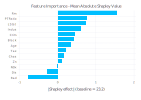

In [23]:
g =  groupby(data_shap, :feature_name)
data_plot = combine(g, :shap_effect => mean)
data_plot = sort(data_plot, order(:shap_effect_mean, rev = true))
baseline = round(data_shap.intercept[1], digits = 1)
p1 = plot(data_plot, y = :feature_name, x = :shap_effect_mean, Coord.cartesian(yflip = true),
         Scale.y_discrete, Geom.bar(position = :dodge, orientation = :horizontal),
         Theme(bar_spacing = 1mm),
         Guide.xlabel("|Shapley effect| (baseline = $baseline)"), Guide.ylabel(nothing),
         Guide.title("Feature Importance - Mean Absolute Shapley Value"));
p1

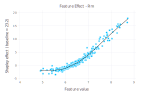

In [24]:
data_plot = data_shap[data_shap.feature_name .== "Rm", :]  # Selecting 1 feature for ease of plotting.
baseline = round(data_shap.intercept[1], digits = 1)
p_points = layer(data_plot, x = :feature_value, y = :shap_effect, Geom.point())
p_line = layer(data_plot, x = :feature_value, y = :shap_effect, Geom.smooth(method = :loess, smoothing = 0.5),
               style(line_width = 0.75mm,), Theme(default_color = "black"))
p2 = plot(p_line, p_points, Guide.xlabel("Feature value"), Guide.ylabel("Shapley effect (baseline = $baseline)"),
         Guide.title("Feature Effect - $(data_plot.feature_name[1])"));
p2

## AutoMLPipeline Zero Coding Using Workflow Template
<center><img src="./template.png" width="1000"/></center>

## Optimal Pipeline Discovery by AutoML
<center><img src="./lowcode.png" width="500"/></center>

## Low vs High Pipeline Complexity
<center><img src="./low-high-comp.png" width="300"/></center>

### Low Complexity Pipeline
<center><img src="./low-comp.png" width="500"/></center>

### High Complexity Pipeline 
<center><img src="./high-comp.png" width="500"/></center>

### [Argo Workflow AutoMLPipeline Demo Link](https://harbeth2.sl.cloud9.ibm.com:2746/workflows/argo/argpassing-low-high-template-kjdkx?tab=workflow&nodeId=argpassing-low-high-template-kjdkx-3259707235&uid=fec891ca-4462-48e1-9c35-a4dcf8acd2c0)